## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [05:17<00:00, 83233.68it/s] 


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 804040.39it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:45<00:00, 98129.22it/s] 


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 140491.49it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):     
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.21
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


Your experiments come here:

In [10]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, training and validation loops here
epochs = 10 # количество эпох (то есть, колечество проходов по тренировочному датасету)
train_loss_history = [] # сюда будем сохранять, как менялось знечение функции потерь по мере обучения

In [11]:
'''
Цикл обучения модели
'''
for i in range(epochs):
    for images_batch, lables_batch in train_loader:    
        # делаем предсказание модели
        prediction = model(images_batch)
        # считаем значение функции потерь
        loss = loss_func(prediction, lables_batch)
        train_loss_history.append(loss.item())

        # вычисляем градиенты
        opt.zero_grad()
        loss.backward()
        # делаем шаг градиентного спуска
        opt.step()

Text(0, 0.5, 'loss')

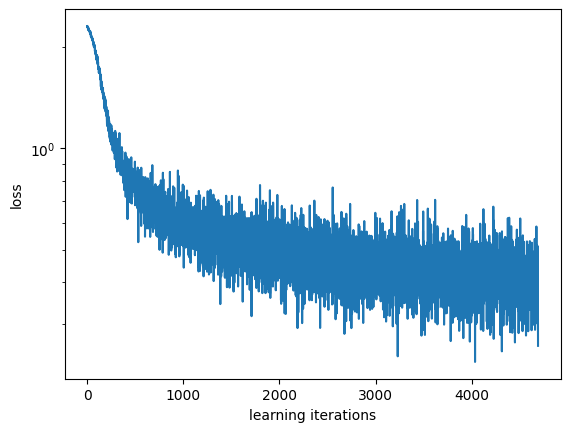

In [12]:
'''
Примечание: ошибка будет очень шумной, так как в модели нет нормировки.
'''
plt.plot(range(len(train_loss_history)), train_loss_history)
plt.gca().set_yscale('log')
plt.xlabel("learning iterations")
plt.ylabel("loss")

In [13]:
# переведем модель в режим НЕ обучения
model.eval()
accuracies = []

# пройдемся батчами по тестовой выборке, посмотрим результат работы сети и выведем среднюю оценку
for x_batch, y_batch in test_loader:
    predicted = model.forward(x_batch).detach().numpy()
    accuracies.append((np.argmax(predicted, axis=1) == y_batch.numpy()).mean())
print(np.array(accuracies).mean())

0.84326171875


### Вывод
Простая нейросеть из 5 слоев выдала вполне себе приемлимый результат 84% точности на тесте. Запомним его.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [14]:
'''
Для того, чтобы переобучить модель увеличим количество нейронов в слоях, а так же, увеличим размер батча.
'''
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [15]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
           Sigmoid-3                 [-1, 1024]               0
            Linear-4                 [-1, 1024]       1,049,600
           Sigmoid-5                 [-1, 1024]               0
            Linear-6                   [-1, 10]          10,250
Total params: 1,863,690
Trainable params: 1,863,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 7.11
Estimated Total Size (MB): 7.15
----------------------------------------------------------------


In [16]:
'''
увеличим размер батча.
'''
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=5000,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=5000,
                                          shuffle=False,
                                          num_workers=2)

In [17]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, training and validation loops here
epochs = 10 # количество эпох (то есть, колечество проходов по тренировочному датасету)
train_loss_history = [] # сюда будем сохранять, как менялось знечение функции потерь по мере обучения

In [18]:
for i in range(epochs):
    for images_batch, lables_batch in train_loader:    
        prediction = model(images_batch)
        loss = loss_func(prediction, lables_batch)
        train_loss_history.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()

Text(0, 0.5, 'loss')

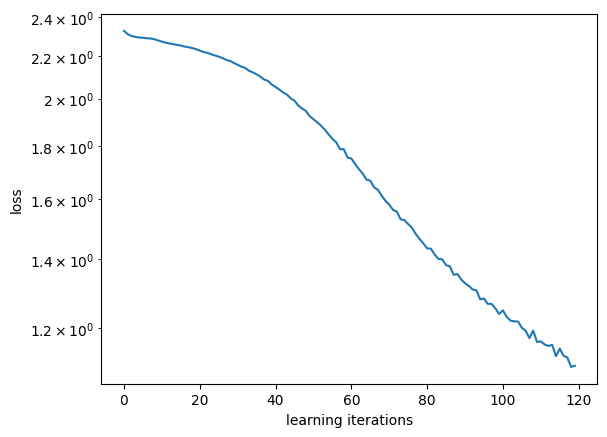

In [19]:
plt.plot(range(len(train_loss_history)), train_loss_history)
plt.gca().set_yscale('log')
plt.xlabel("learning iterations")
plt.ylabel("loss")

In [20]:
# переведем модель в режим НЕ обучения
model.eval()
accuracies = []

# пройдемся батчами по тестовой выборке, посмотрим результат работы сети и выведем среднюю оценку
for x_batch, y_batch in test_loader:
    predicted = model.forward(x_batch).detach().numpy()
    accuracies.append((np.argmax(predicted, axis=1) == y_batch.numpy()).mean())
print(np.array(accuracies).mean())

0.6468


### Вывод
В исходной сети мы просто увеличили количество параметров. Как видно из графика, на тренеровочной выборке в процессе обучения ошибка продолжает падать, в то время как на тестовой выборке точность упала на 20% по сравнению с простой сетью. Это свидетельствует о переобучении модели.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [21]:
'''
Добавим нормировку данных и dropout для того, чтобы компенсировать переобучение.
'''
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024, momentum=0.9),
            nn.Dropout(0.25),
            nn.Sigmoid(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, momentum=0.9),
            nn.Dropout(0.25),
            nn.Sigmoid(),
            nn.Linear(1024, num_classes),
            nn.BatchNorm1d(num_classes, momentum=0.9),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [22]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
       BatchNorm1d-3                 [-1, 1024]           2,048
           Dropout-4                 [-1, 1024]               0
           Sigmoid-5                 [-1, 1024]               0
            Linear-6                 [-1, 1024]       1,049,600
       BatchNorm1d-7                 [-1, 1024]           2,048
           Dropout-8                 [-1, 1024]               0
           Sigmoid-9                 [-1, 1024]               0
           Linear-10                   [-1, 10]          10,250
      BatchNorm1d-11                   [-1, 10]              20
          Softmax-12                   [-1, 10]               0
Total params: 1,867,806
Trainable params: 1,867,806
Non-trainable params: 0
---------------------------

In [23]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=2000,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=2000,
                                          shuffle=False,
                                          num_workers=2)

In [24]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, training and validation loops here
epochs = 10 # количество эпох (то есть, колечество проходов по тренировочному датасету)
train_loss_history = [] # сюда будем сохранять, как менялось знечение функции потерь по мере обучения

In [25]:
for i in range(epochs):
    for images_batch, lables_batch in train_loader:    
        prediction = model(images_batch)
        loss = loss_func(prediction, lables_batch)
        train_loss_history.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()

Text(0, 0.5, 'loss')

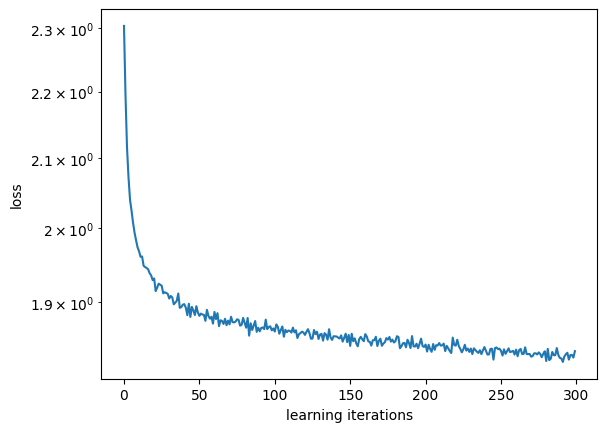

In [26]:
plt.plot(range(len(train_loss_history)), train_loss_history)
plt.gca().set_yscale('log')
plt.xlabel("learning iterations")
plt.ylabel("loss")

In [28]:
# переведем модель в режим НЕ обучения
model.eval()
accuracies = []

# пройдемся батчами по тестовой выборке, посмотрим результат работы сети и выведем среднюю оценку
for x_batch, y_batch in test_loader:
    predicted = model.forward(x_batch).detach().numpy()
    accuracies.append((np.argmax(predicted, axis=1) == y_batch.numpy()).mean())
print(np.array(accuracies).mean())

0.8325999999999999


### Вывод
С помощью нормировки и dropout нам удалось вернуть качество модели в 84%.

### Conclusions:
_Write down small report with your conclusions and your ideas._